# Bayesian Exploration
Here we demonstrate the use of Bayesian Exploration to characterize an unknown
function in the presence of constraints (see [here](https://www.nature.com/articles/s41467-021-25757-3)).
The function we wish to explore is the first objective of the TNK test problem.

## Specifiying generator options
We start with the generator defaults and modify as needed for conservative
exploration, which should prevent any constraint violations.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)
vocs.objectives = {}
vocs.observables = ["y1"]

generator = BayesianExplorationGenerator(vocs=vocs)
generator.max_travel_distances = [0.25, 0.25]
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = NUM_MC_SAMPLES

evaluator = Evaluator(function=evaluate_TNK)

X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 0+untagged.1508.ga613b00.dirty
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances:
  - 0.25
  - 0.25
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
ser

## Run exploration
We start with evaluating 2 points that we know satisfy the constraints. We then run
30 exploration steps.

In [2]:
X.evaluate_data({"x1":[1.0, 0.75],"x2":[0.7, 0.95]})

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.00,0.70,dummy_constant,1.00,0.70,0.584045,0.290,0.000020,False
1,0.75,0.95,dummy_constant,0.75,0.95,0.494833,0.265,0.000018,False


In [3]:
for i in range(2):
    print(f"step {i}")
    X.step()

step 0
step 1


In [4]:
# view the data
X.data

,x1,x2,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.000000,0.700000,dummy_constant,1.000000,0.700000,0.584045,0.290000,0.000020,False
1,0.750000,0.950000,dummy_constant,0.750000,0.950000,0.494833,0.265000,0.000018,False
2,1.535397,1.735397,dummy_constant,1.535397,1.735397,4.313110,2.598255,0.000020,False
3,2.320795,0.950000,dummy_constant,2.320795,0.950000,5.188811,3.517794,0.000015,False


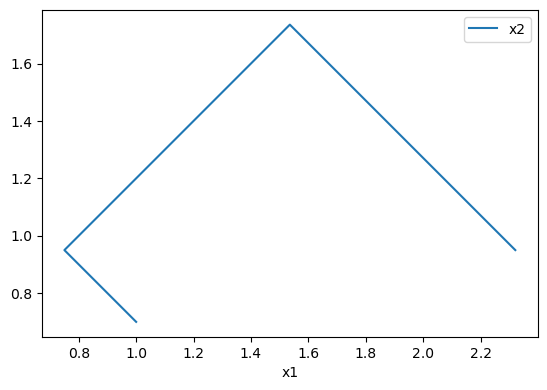

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

## Introspect models, acquisition function and feasibility prediction
During exploration we generate Gaussian Process models of each objective and
constraint. We demonstrate how they are viewed below.

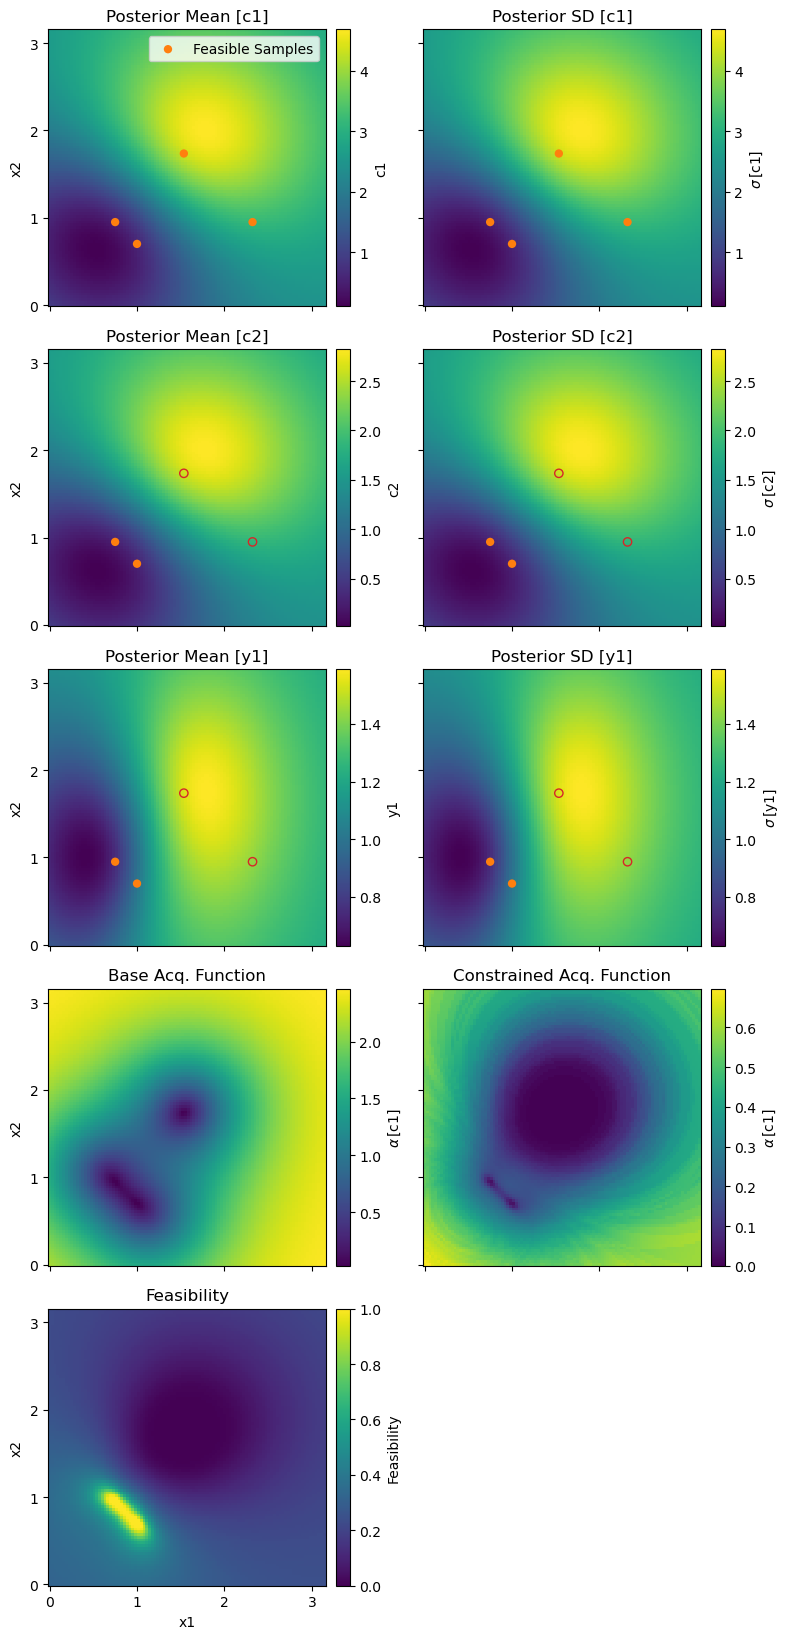

In [6]:
fig, ax = X.generator.visualize_model(show_feasibility=True, n_grid=100)

## Generator model hyperparameters

In [7]:
# print generator model hyperparameters
for name, val in X.generator.model.named_parameters():
    print(f"{name}:{val}")

X.generator.model.models[2].covar_module.base_kernel.lengthscale

models.0.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-22.1766], dtype=torch.float64, requires_grad=True)
models.0.mean_module.raw_constant:Parameter containing:
tensor(0.2642, dtype=torch.float64, requires_grad=True)
models.0.covar_module.raw_outputscale:Parameter containing:
tensor(1.9192, dtype=torch.float64, requires_grad=True)
models.0.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.8180, -0.8447]], dtype=torch.float64, requires_grad=True)
models.1.likelihood.noise_covar.raw_noise:Parameter containing:
tensor([-22.6121], dtype=torch.float64, requires_grad=True)
models.1.mean_module.raw_constant:Parameter containing:
tensor(0.2634, dtype=torch.float64, requires_grad=True)
models.1.covar_module.raw_outputscale:Parameter containing:
tensor(1.9071, dtype=torch.float64, requires_grad=True)
models.1.covar_module.base_kernel.raw_lengthscale:Parameter containing:
tensor([[-0.8057, -0.8525]], dtype=torch.float64, requires_grad=True)
models.2.lik

tensor([[0.2796, 0.4021]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)

## Examine the number of constraint violations
Using the convience function provided by the vocs object we can evaluate which
samples violate either or both of our constraints.

In [8]:
X.vocs.feasibility_data(X.data)

,feasible_c1,feasible_c2,feasible
0,True,True,True
1,True,True,True
2,True,False,False
3,True,False,False


In [9]:
# generate next point
X.generator.generate(1)

[{'x1': 1.545345316199704, 'x2': 0.16460249999999998}]